In [16]:
import sys
import random
import time
import numpy as np, pandas as pd
from tqdm import tqdm
from math import log10
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch_geometric.transforms as T
from torch.utils.data import random_split, DataLoader

from dataset import fn, custom_InMemoryDataset, NewDataset_w_sph
from train import *
from model import Gradformer_DownstreamTasks 

In [2]:
def canonize(df):
    canonical_list = [Chem.MolToSmiles(Chem.MolFromSmiles(smi), isomericSmiles = False) for smi in df['SMILES']]
    df['SMILES'] = canonical_list
    return df

In [3]:
seed = 42
esol_path = 'esol.txt'
esol= pd.read_csv(esol_path , delimiter = ',')
df = esol

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1144 entries, 0 to 1143
Data columns (total 4 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Compound ID                           1144 non-null   object 
 1   measured log(solubility:mol/L)        1144 non-null   float64
 2   ESOL predicted log(solubility:mol/L)  1144 non-null   float64
 3   SMILES                                1144 non-null   object 
dtypes: float64(2), object(2)
memory usage: 35.9+ KB


In [5]:
# drop duplicates
df = canonize(df)
df = df.drop(columns = ['Compound ID', 'ESOL predicted log(solubility:mol/L)'])
df_avg = df.groupby('SMILES').mean().reset_index()
df = df_avg

In [6]:
df['S0'] = df['measured log(solubility:mol/L)']
df['S0'].describe()

count    1144.000000
mean       -3.057997
std         2.096502
min       -11.600000
25%        -4.332250
50%        -2.870500
75%        -1.600000
max         1.580000
Name: S0, dtype: float64

In [7]:
def tolog10(x):
    try:    o= log10(x)
    except:        o= np.nan
    return o

nonlog10=['S0'] 
properties=nonlog10

df_clean=df

,measured log(solubility:mol/L),SMILES,S0
0,-2.180,ClCC(Cl)(Cl)Cl,-2.180
1,-2.000,CC(Cl)(Cl)Cl,-2.000
2,-1.740,ClC(Cl)C(Cl)Cl,-1.740
3,-1.480,ClCC(Cl)Cl,-1.480
4,-3.040,FC(F)(Cl)C(F)(Cl)Cl,-3.040
...,...,...,...
1139,1.144,CNC(=O)C(C)SCCSP(=O)(OC)OC,1.144
1140,-4.925,C=CC1(C)OC(=O)N(c2cc(Cl)cc(Cl)c2)C1=O,-4.925
1141,-3.893,CC(=O)CC(c1ccccc1)c1c(O)c2ccccc2oc1=O,-3.893
1142,-3.790,Cc1cccc(C)c1NC(=O)c1cc(S(N)(=O)=O)c(Cl)cc1O,-3.790


In [8]:
from sklearn.model_selection import train_test_split

y_bins = pd.cut(df['S0'], bins = 5)
train_df, test_valid = train_test_split( df_clean,  test_size=0.3 , stratify=y_bins,random_state =seed)
y_bins_2 = pd.cut(test_valid['S0'], bins = 5)
test_df, validation = train_test_split( test_valid,  test_size=0.5, stratify=y_bins_2,random_state =seed)

len(train_df), len(test_df), len(validation)
train_df.reset_index(drop=True , inplace=True)
test_df.reset_index(drop=True , inplace=True)
validation.reset_index(drop=True , inplace=True)


(array([ 1.,  0.,  4.,  8., 15., 32., 44., 39., 20.,  9.]),
 array([-11.6  , -10.282,  -8.964,  -7.646,  -6.328,  -5.01 ,  -3.692,
         -2.374,  -1.056,   0.262,   1.58 ]),
 <BarContainer object of 10 artists>)

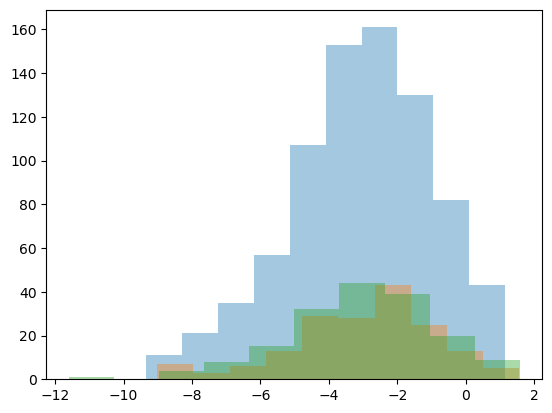

In [9]:
import matplotlib.pyplot as plt
plt.hist(train_df['S0'], alpha = 0.4)
plt.hist(test_df['S0'],  alpha = 0.4)
plt.hist(validation['S0'],  alpha = 0.4)

In [12]:
folder=f'esol_run'
!mkdir {folder}

In [13]:
train_df.to_csv(f'{folder}/Training_data_ALL_ADME.csv.gz',index =False,          compression="gzip")
validation.to_csv(f'{folder}/validation_data_ALL_ADME.csv.gz',index =False,            compression="gzip")
test_df.to_csv(f'{folder}/Test_data_ALL_ADME.csv.gz',index =False,            compression="gzip")

In [14]:
properties=properties=['S0']
pre_transform = T.AddRandomWalkPE(walk_length=20, attr_name='pe')
dataset_train=custom_InMemoryDataset( df=train_df,properties=properties,smiles="SMILES", pre_transform=pre_transform, root=f'{folder}/train')
dataset_train_sph = NewDataset_w_sph(dataset_train)
dataset_test=custom_InMemoryDataset( df=test_df,properties=properties,smiles="SMILES", pre_transform=pre_transform, root=f'{folder}/test')
dataset_test_sph = NewDataset_w_sph(dataset_test)
dataset_validation=custom_InMemoryDataset( df=validation,properties=properties,smiles="SMILES", pre_transform=pre_transform, root=f'{folder}/vald')
dataset_validation_sph = NewDataset_w_sph(dataset_validation)
#dataset[22]

Processing...


Converting SMILES strings into graphs...


100%|██████████| 800/800 [00:00<00:00, 818.83it/s]
Done!


Saving...
pre-process sph start!


pre-processing Data: 100%|█| 800/800 [00
Processing...


pre-process sph done!
Converting SMILES strings into graphs...


100%|██████████| 172/172 [00:00<00:00, 809.82it/s]
Done!


Saving...
pre-process sph start!


pre-processing Data: 100%|█| 172/172 [00
Processing...


pre-process sph done!
Converting SMILES strings into graphs...


100%|██████████| 172/172 [00:00<00:00, 801.13it/s]
Done!


Saving...
pre-process sph start!


pre-processing Data: 100%|█| 172/172 [00


pre-process sph done!


In [17]:
batch_size=75
train_loader = DataLoader(dataset_train_sph, batch_size=batch_size, shuffle=True, collate_fn=fn)
val_loader = DataLoader(dataset_validation_sph, batch_size=3*batch_size, collate_fn=fn)
test_loader = DataLoader(dataset_test_sph, batch_size=3*batch_size, collate_fn=fn)
batch=next(iter(train_loader))

DataBatch(edge_index=[2, 2292], edge_attr=[2292, 3], x=[1102, 9], S0=[75], pe=[1102, 20], sph=[4050, 54], batch=[1102], ptr=[76])

In [20]:
pred_hidden_dropout=0.1
tasks={}
for p in properties:#['log_Human_PPB_Cyprotex %Free (%)', 'log_Rat_PPB_Cyprotex %Free (%)','log_Mouse_PPB_Cyprotex %Free (%)']:
    tasks[p] = {'is_regression':1, 'n_output':1,'n_layers':1 ,'pred_hidden_dropout':pred_hidden_dropout,'out_dim': 50}

In [21]:
device , device_ids=set_device(with_cuda=True, cuda_devices= 'all')
device , device_ids

Using one GPU


(device(type='cuda', index=0), [0])

In [22]:
model = Gradformer_DownstreamTasks( tasks, fine_tune_scale=1 ,lr=0.0005 , encoder= 'new').to(device)
optimizer=model.optimizer

the learning rate of the encoder is scaled by 1


In [23]:
FAC_LR_HOP=10
lr=0.0005
parm_groups=[{ 'params': [param for name, param in model.named_parameters() if 'encoder.hop'  in name], 'lr': FAC_LR_HOP*lr }]

parm_groups+=[{ 'params': [param for name, param in model.named_parameters() if 'encoder.hop' not in name], 'lr': lr }]
optimizer=optim.Adam(parm_groups, lr=lr)

In [24]:
out_dir=f'{folder}/train_logs' 
#'/workspace/ALL_ADME' 
trainer= Task_trainer( model= model ,
                          mutitasks=False,
                 out_dir=out_dir,
                 device=device,
                 device_ids=device_ids,
                 optimizer=optimizer,
                # vocab=vocab,
                 lr= 0.005,
                 eval_every_epoch=1,
                  print_logs_every=5, 
                verbose=True,
                 log_freq= 100 )
trainer.early_stopping=30

In [25]:
trainer.fit(train_dataloader=train_loader,test_dataloader=test_loader ,eval_every_epoch=1,nr_epochs=200)#,nr_gpus=-1)

Number of training batchs is 11
saving the outputs in folder esol_run/train_logs
number of training epochs = 200


Train_Epoch:1:Batch: 100%|██████████| 11/11 [00:01<00:00, 10.57it/s]


Saving the checkpoint and the best model which is found at epoch 1...
 Losses and metrics of epoch 1: 
S0: Pre-fit train-loss=9.4784568 |Eval-loss=10.2765207 |Eval metric R2=-1.2620 |uncertainty=1.0000


Train_Epoch:2:Batch: 100%|██████████| 11/11 [00:00<00:00, 18.33it/s]


Saving the checkpoint and the best model which is found at epoch 2...


Train_Epoch:3:Batch: 100%|██████████| 11/11 [00:00<00:00, 18.43it/s]


Saving the checkpoint and the best model which is found at epoch 3...


Train_Epoch:4:Batch: 100%|██████████| 11/11 [00:00<00:00, 16.93it/s]


Saving the checkpoint and the best model which is found at epoch 4...


Train_Epoch:5:Batch: 100%|██████████| 11/11 [00:00<00:00, 16.01it/s]


Saving the checkpoint and the best model which is found at epoch 5...


Train_Epoch:6:Batch: 100%|██████████| 11/11 [00:00<00:00, 16.92it/s]


Saving the checkpoint and the best model which is found at epoch 6...
 Losses and metrics of epoch 6: 
S0: Pre-fit train-loss=3.8613947 |Eval-loss=3.0878034 |Eval metric R2=0.3203 |uncertainty=1.0000


Train_Epoch:7:Batch: 100%|██████████| 11/11 [00:00<00:00, 17.94it/s]


Saving the checkpoint and the best model which is found at epoch 7...


Train_Epoch:8:Batch: 100%|██████████| 11/11 [00:00<00:00, 20.72it/s]


Saving the checkpoint and the best model which is found at epoch 8...


Train_Epoch:9:Batch: 100%|██████████| 11/11 [00:00<00:00, 18.76it/s]


Saving the checkpoint and the best model which is found at epoch 9...


Train_Epoch:10:Batch: 100%|██████████| 11/11 [00:00<00:00, 19.21it/s]


Saving the checkpoint and the best model which is found at epoch 10...


Train_Epoch:11:Batch: 100%|██████████| 11/11 [00:00<00:00, 19.24it/s]


 Losses and metrics of epoch 11: 
S0: Pre-fit train-loss=1.8313645 |Eval-loss=1.5829705 |Eval metric R2=0.6516 |uncertainty=1.0000


Train_Epoch:12:Batch: 100%|██████████| 11/11 [00:00<00:00, 19.30it/s]


Saving the checkpoint and the best model which is found at epoch 12...


Train_Epoch:15:Batch: 100%|██████████| 11/11 [00:00<00:00, 19.89it/s]


Saving the checkpoint and the best model which is found at epoch 15...


Train_Epoch:16:Batch: 100%|██████████| 11/11 [00:00<00:00, 19.01it/s]


Saving the checkpoint and the best model which is found at epoch 16...
 Losses and metrics of epoch 16: 
S0: Pre-fit train-loss=1.0794436 |Eval-loss=0.9800958 |Eval metric R2=0.7843 |uncertainty=1.0000


Train_Epoch:21:Batch: 100%|██████████| 11/11 [00:00<00:00, 19.41it/s]


 Losses and metrics of epoch 21: 
S0: Pre-fit train-loss=0.8381682 |Eval-loss=1.0066231 |Eval metric R2=0.7784 |uncertainty=1.0000


Train_Epoch:22:Batch: 100%|██████████| 11/11 [00:00<00:00, 19.21it/s]


Saving the checkpoint and the best model which is found at epoch 22...


Train_Epoch:25:Batch: 100%|██████████| 11/11 [00:00<00:00, 19.38it/s]


Saving the checkpoint and the best model which is found at epoch 25...


Train_Epoch:26:Batch: 100%|██████████| 11/11 [00:00<00:00, 19.25it/s]


 Losses and metrics of epoch 26: 
S0: Pre-fit train-loss=0.7172672 |Eval-loss=0.6658943 |Eval metric R2=0.8534 |uncertainty=1.0000


Train_Epoch:31:Batch: 100%|██████████| 11/11 [00:00<00:00, 19.19it/s]


 Losses and metrics of epoch 31: 
S0: Pre-fit train-loss=0.6348331 |Eval-loss=0.6616949 |Eval metric R2=0.8544 |uncertainty=1.0000


Train_Epoch:32:Batch: 100%|██████████| 11/11 [00:00<00:00, 19.11it/s]


Saving the checkpoint and the best model which is found at epoch 32...


Train_Epoch:33:Batch: 100%|██████████| 11/11 [00:00<00:00, 17.82it/s]


Saving the checkpoint and the best model which is found at epoch 33...


Train_Epoch:34:Batch: 100%|██████████| 11/11 [00:00<00:00, 15.63it/s]


Saving the checkpoint and the best model which is found at epoch 34...


Train_Epoch:36:Batch: 100%|██████████| 11/11 [00:00<00:00, 15.63it/s]


Saving the checkpoint and the best model which is found at epoch 36...
 Losses and metrics of epoch 36: 
S0: Pre-fit train-loss=0.5550775 |Eval-loss=0.4702657 |Eval metric R2=0.8965 |uncertainty=1.0000


Train_Epoch:38:Batch: 100%|██████████| 11/11 [00:00<00:00, 18.99it/s]


Saving the checkpoint and the best model which is found at epoch 38...


Train_Epoch:41:Batch: 100%|██████████| 11/11 [00:00<00:00, 19.25it/s]


 Losses and metrics of epoch 41: 
S0: Pre-fit train-loss=0.6101783 |Eval-loss=0.6595687 |Eval metric R2=0.8548 |uncertainty=1.0000


Train_Epoch:46:Batch: 100%|██████████| 11/11 [00:00<00:00, 16.56it/s]


 Losses and metrics of epoch 46: 
S0: Pre-fit train-loss=0.4238012 |Eval-loss=0.5457426 |Eval metric R2=0.8799 |uncertainty=1.0000


Train_Epoch:49:Batch: 100%|██████████| 11/11 [00:00<00:00, 17.05it/s]


Saving the checkpoint and the best model which is found at epoch 49...


Train_Epoch:50:Batch: 100%|██████████| 11/11 [00:00<00:00, 15.14it/s]


Saving the checkpoint and the best model which is found at epoch 50...


Train_Epoch:51:Batch: 100%|██████████| 11/11 [00:00<00:00, 16.09it/s]


 Losses and metrics of epoch 51: 
S0: Pre-fit train-loss=0.4586034 |Eval-loss=0.5567865 |Eval metric R2=0.8774 |uncertainty=1.0000


Train_Epoch:56:Batch: 100%|██████████| 11/11 [00:00<00:00, 18.29it/s]


 Losses and metrics of epoch 56: 
S0: Pre-fit train-loss=0.4252413 |Eval-loss=0.6150478 |Eval metric R2=0.8646 |uncertainty=1.0000


Train_Epoch:61:Batch: 100%|██████████| 11/11 [00:00<00:00, 18.60it/s]


 Losses and metrics of epoch 61: 
S0: Pre-fit train-loss=0.3469347 |Eval-loss=0.5984927 |Eval metric R2=0.8683 |uncertainty=1.0000


Train_Epoch:66:Batch: 100%|██████████| 11/11 [00:00<00:00, 21.20it/s]


 Losses and metrics of epoch 66: 
S0: Pre-fit train-loss=0.3896935 |Eval-loss=0.5408967 |Eval metric R2=0.8809 |uncertainty=1.0000


Train_Epoch:71:Batch: 100%|██████████| 11/11 [00:00<00:00, 18.40it/s]


 Losses and metrics of epoch 71: 
S0: Pre-fit train-loss=0.3706390 |Eval-loss=0.4702947 |Eval metric R2=0.8965 |uncertainty=1.0000


Train_Epoch:76:Batch: 100%|██████████| 11/11 [00:00<00:00, 20.96it/s]


 Losses and metrics of epoch 76: 
S0: Pre-fit train-loss=0.2876214 |Eval-loss=0.4055344 |Eval metric R2=0.9107 |uncertainty=1.0000


Train_Epoch:81:Batch: 100%|██████████| 11/11 [00:00<00:00, 18.30it/s]


 Losses and metrics of epoch 81: 
S0: Pre-fit train-loss=0.2525244 |Eval-loss=0.4691708 |Eval metric R2=0.8967 |uncertainty=1.0000
No improvment after 30 ..stopping...
Total Training Time: 1.39 min
Best model is found at epoch 50


In [26]:
trainer.load_checkpoint(best_model=True)
trainer.print_logs()

loading checkpoint from file: esol_run/train_logs/checkpoint_best_model.pt
Model parameters are loaded from the checkpoint
Optimizer parameters are loaded from the checkpoint
Scheduler parameters are loaded from the checkpoint
 Losses and metrics of epoch 50: 
S0: Pre-fit train-loss=0.4739053 |Eval-loss=0.3688685 |Eval metric R2=0.9188 |uncertainty=1.0000


In [27]:
%%time
smiles=validation.SMILES
out=model.predict( smiles, batch_size=200, convert_log10=True)

CPU times: user 31.6 ms, sys: 150 ms, total: 182 ms
Wall time: 538 ms


In [28]:
y_true = validation['S0']
y_pred = out['predicted_S0']

In [29]:
def metric(y_pred,y):
    rmse = mean_squared_error(y, y_pred ,squared=False)
    r_2 = r2_score(y,y_pred)
    return rmse, r_2
metric(y_pred, y_true)

(0.6404890891615627, 0.9131564454525624)

In [30]:
y_true_SC2 = validation['S0']
y_pred_SC2 = out['predicted_S0']

Text(0, 0.5, 'y_pred')

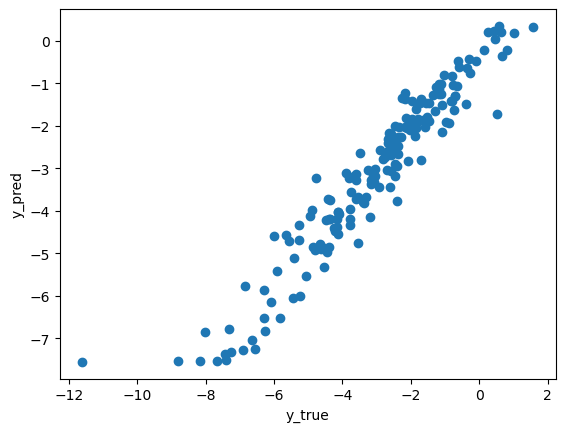

In [48]:
plt.scatter(y_true, y_pred)
plt.xlabel('y_true')
plt.ylabel('y_pred')

In [40]:
t = time.localtime()
current_time = time.strftime("%D", t)
print(current_time)

09/02/25


In [56]:
out={}
out['date']= current_time
out['model']= model
out['model_state_dict']= model.state_dict()

torch.save(out,  f'esol_single{seed}.pt')